#### kmeans on embeddings with elbow curve and silhouette analysis

In [1]:
from sklearn.cluster import KMeans
import pickle 
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib

In [5]:
# load embeddings and their labels 

with open('data/vb_obj_ftext_ner.pkl', 'rb') as f:
    vo_rep  = pickle.load(f)

with open('data/vb_obj_ner_ftextLabels.pkl', 'rb') as f:
    lab_vec_map = pickle.load(f)

label = []
for vec in vo_rep:
    label.append(lab_vec_map[str(vec)])

print(len(vo_rep))


6425


In [4]:
# reduce dimensions and standardize values
X = np.array(vo_rep) 
rX = PCA(n_components=50).fit_transform(X)


X = StandardScaler().fit_transform(rX)
print(X.shape)

(6425, 50)


#### plot elbow curve for finding n_clusters

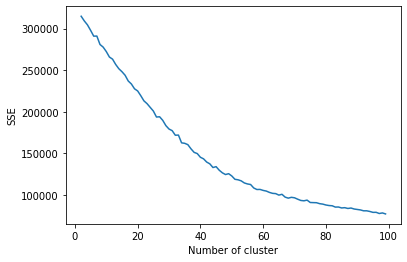

In [9]:
sse = {}

for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=1).fit(X)
    labels = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center 

    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [63]:
### silhouette analysis - n with higher score around the elbow value is good

range_n_clusters = [40,42,43,44,45,46,52,53,54,55,56,57,58,59,60,61,62,63]
figures = []


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig = tools.make_subplots(rows=1, cols=2,
                              print_grid=False,
                              subplot_titles=('The silhouette plot for the various clusters.',
                                              'The visualization of the clustered data.'))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    fig['layout']['xaxis1'].update(title='The silhouette coefficient values',
                                   range=[-1, 1])
   
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    fig['layout']['yaxis1'].update(title='Cluster label',
                                   showticklabels=False,
                                   range=[0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    print(cluster_labels)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

#         colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        cmap = cm.get_cmap("Spectral")
        colors = cmap(cluster_labels / n_clusters)
        
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper),
                                 x=ith_cluster_silhouette_values,
                                 mode='lines',
                                 showlegend=False,
                                 line=dict(width=0.5,
                                          color=colors),
                                 fill='tozerox'
                                )
        fig.append_trace(filled_area, 1, 1)
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        

    # The vertical line for average silhouette score of all the values
    axis_line = go.Scatter(x=[silhouette_avg],
                           y=[0, len(X) + (n_clusters + 1) * 10],
                           showlegend=False,
                           mode='lines',
                           line=dict(color="red", dash='dash',
                                     width =1) )

    fig.append_trace(axis_line, 1, 1)
    
    # 2nd Plot showing the actual clusters formed
    
    colors = matplotlib.colors.colorConverter.to_rgb(cmap(float(i) / n_clusters))
    colors = 'rgb'+str(colors)
    clusters = go.Scatter(x=X[:, 0], 
                          y=X[:, 1], 
                          showlegend=False,
                          mode='markers',
                          marker=dict(color=colors,
                                     size=4)
                         )
    fig.append_trace(clusters, 1, 2)
    
    # Labeling the clusters
    centers_ = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    centers = go.Scatter(x=centers_[:, 0], 
                         y=centers_[:, 1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(color='green', size=10,
                                     line=dict(color='black',
                                                             width=1))
                        )

    fig.append_trace(centers, 1, 2)
    
    fig['layout']['xaxis2'].update(title='Feature space for the 1st feature',
                                   zeroline=False)
    fig['layout']['yaxis2'].update(title='Feature space for the 2nd feature',
                                  zeroline=False)
                              

    fig['layout'].update(title="Silhouette analysis for KMeans clustering on sample data "
                         "with n_clusters = %d" % n_clusters)
    
    figures.append(fig)

[ 0  0  0 ... 25 34  6]
For n_clusters = 52 The average silhouette_score is : 0.46571034
[39  2  2 ...  0 13 26]
For n_clusters = 53 The average silhouette_score is : 0.47843617
[49  0  0 ... 50 28 50]
For n_clusters = 54 The average silhouette_score is : 0.4891542
[50  1  1 ... 37 11 37]
For n_clusters = 55 The average silhouette_score is : 0.4928847
[43  1  1 ... 44 29 42]
For n_clusters = 56 The average silhouette_score is : 0.49054626
[50  1  1 ... 53 31 32]
For n_clusters = 57 The average silhouette_score is : 0.48307347
[48  4  4 ...  0 29  0]
For n_clusters = 58 The average silhouette_score is : 0.48680505
[55  0  0 ... 24  9 53]
For n_clusters = 59 The average silhouette_score is : 0.49755704
[43  4  4 ... 53 10 51]
For n_clusters = 60 The average silhouette_score is : 0.491469
[ 0  1  1 ... 39 30 39]
For n_clusters = 61 The average silhouette_score is : 0.5007934
[ 1  1  1 ... 56 13 39]
For n_clusters = 62 The average silhouette_score is : 0.5067101
[56  2  2 ... 55 28 54]
For

In [64]:
from  plotly.offline import plot
plot(figures[-6])

'file:///home/rrichajalota/work/DBpedia Chatlog Analysis/temp-plot.html'

In [50]:
plot(figures[12])

'file:///home/rrichajalota/work/DBpedia Chatlog Analysis/temp-plot.html'

In [51]:
plot(figures[11])

'file:///home/rrichajalota/work/DBpedia Chatlog Analysis/temp-plot.html'

In [31]:
plot(figures[3])

'file:///home/rrichajalota/work/DBpedia Chatlog Analysis/temp-plot.html'

In [17]:
plot(figures[4])

'file:///home/rrichajalota/work/DBpedia Chatlog Analysis/temp-plot.html'

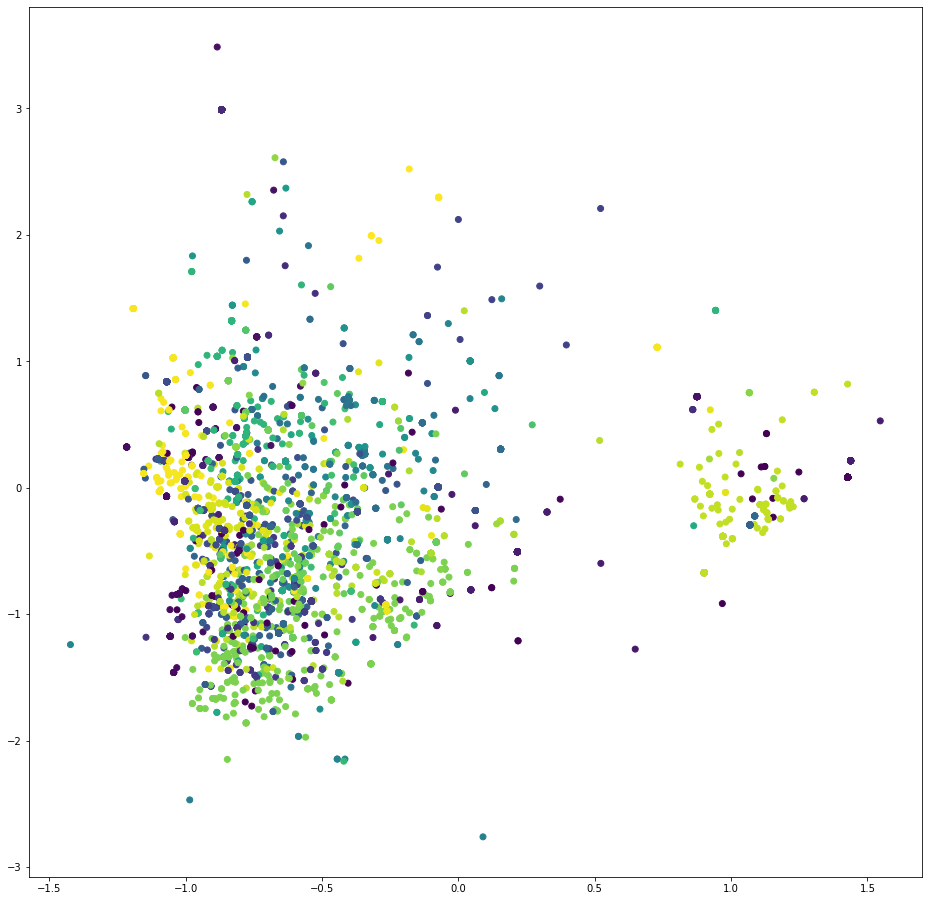

In [72]:
# plot the clusters
import matplotlib.pyplot as plt

# Scaling the data to normalize
model = KMeans(n_clusters=67).fit(X)

# Visualize it:
plt.figure(figsize=(16, 16))
plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))

In [66]:
# find the no. of points in each cluster
from collections import Counter, defaultdict
print(Counter(model.labels_))

67
Counter({2: 1817, 7: 430, 49: 335, 1: 305, 38: 297, 4: 283, 0: 267, 9: 223, 3: 186, 63: 182, 37: 177, 41: 171, 64: 118, 17: 111, 23: 103, 10: 84, 65: 72, 47: 71, 12: 71, 45: 64, 14: 61, 46: 59, 39: 56, 40: 54, 25: 50, 43: 49, 60: 48, 29: 40, 26: 38, 31: 36, 59: 36, 24: 34, 32: 33, 51: 33, 55: 32, 56: 28, 54: 28, 48: 27, 35: 23, 34: 23, 20: 20, 33: 18, 53: 17, 61: 17, 27: 16, 42: 16, 15: 16, 66: 14, 18: 14, 8: 12, 16: 12, 6: 11, 11: 10, 62: 10, 57: 9, 36: 9, 52: 7, 30: 7, 58: 6, 21: 5, 19: 5, 13: 5, 5: 4, 50: 4, 44: 3, 28: 2, 22: 1})


In [67]:
centroids  = kmeans.cluster_centers_
centroid_labels = [centroids[i] for i in labels]
print(centroid_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [74]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(67):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % label[ind])
    print

    

Top terms per cluster:
Cluster 0:
 who church
 what organization
 swife？ who
 person who
 get city
 person who
 learn person
 city germany
 person who
 get city
Cluster 1:
 get city
 what organization
 person who
 person who
 get city
 person who
 what organization
 person who
 name cat
 person who
Cluster 2:
 swife？ who
 person who
 get city
 birthdate person
 person who
 learn county
 what place
 population country
 what organization
 learning tower
Cluster 3:
 place country
 place lithuania
 learn county
 get city
 mayor place
 what organization
 get city
 person who
 person who
 tower place
Cluster 4:
 person who
 person who
 get city
 get city
 directed creativework
 place country
 what organization
 load person
 what place
 place lithuania
Cluster 5:
 load person
 get city
 person who
 learn person
 person who
 get city
 load person
 get city
 get city
 place lithuania
Cluster 6:
 mountain who
 get city
 what country
 person who
 get city
 tower place
 swife？ who
 get city
 learn

/home/rrichajalota/work/DBpedia Chatlog Analysis/venv/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


/home/rrichajalota/work/DBpedia Chatlog Analysis/venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 23 separate connected components using meta-embedding (experimental)

/home/rrichajalota/work/DBpedia Chatlog Analysis/venv/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



IndexError: tuple index out of range

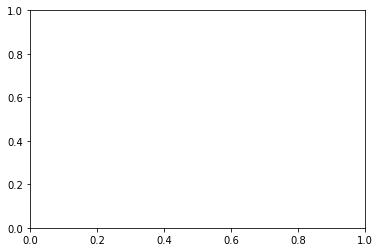

In [9]:
# # using umap
# import umap
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# standard_embedding = umap.UMAP(random_state=42).fit_transform(X)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=len(label), s=0.1, cmap='Spectral')

In [ ]:
# #reduce the features to 2D
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2, random_state=42)
# reduced_features = pca.fit_transform(vo_pair)

# # reduce the cluster centers to 2D
# reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

In [ ]:
# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(vo_pair))
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [ ]:
# import collections
# clustering = collections.defaultdict(list)
 
# for idx, label in enumerate(kmeans.labels_):
#     clustering[label].append(idx)

# pprint.pprint(clustering)